In [18]:
import pandas as pd
import numpy as np

df = pd.read_csv('duration.csv')
df.columns = ['uid', 'duration']

df.head()

,uid,duration
0,5a94fae988095227d0439a01,61
1,5a619af83dfd886190dc3348,22
2,59e0c66216543644d5827cde,3
3,59f4767d5e14b5071fb7b65a,31
4,59be1a6ed4bbfb078f408307,24


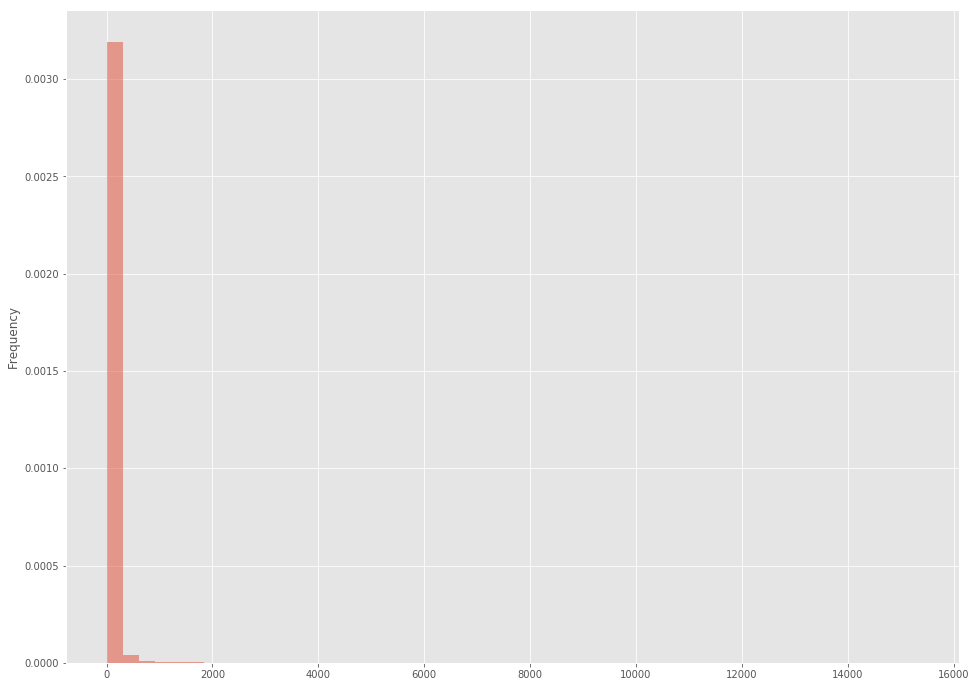

In [19]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

duration = df['duration']
matplotlib.rcParams['figure.figsize'] = (16., 12.)
matplotlib.style.use('ggplot')

ax = duration.plot(kind='hist', bins=50, density=True, alpha=0.5)

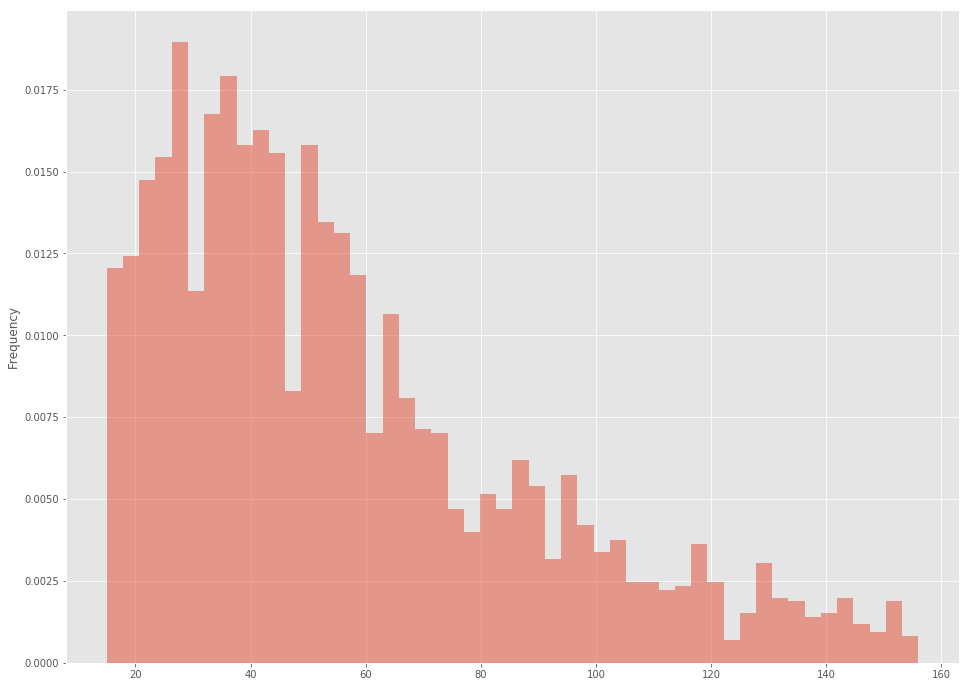

In [20]:
def reject_outliers(data, m=2, min_thres=10, max_thres=200):
    d = data[data <= max_thres]
    d = d[d >= min_thres]
    return d[abs(d - np.mean(d)) < m * np.std(d)]

f_duration = reject_outliers(duration, m=1.8, min_thres=15, max_thres=300)
ax = f_duration.plot(kind='hist', bins=50, density=True, alpha=0.5)

In [21]:
import warnings
import scipy.stats as st
import statsmodels as sm

DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,\
        st.burr,st.cauchy,st.chi,st.chi2,st.cosine, st.dgamma,\
        st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,\
        st.exponpow,st.f,st.fatiguelife,st.fisk,st.foldcauchy,st.foldnorm,\
        st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,\
        st.gennorm,st.genexpon,st.genextreme,st.gausshyper,st.gamma,\
        st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,\
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,\
        st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,st.invweibull,\
        st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,\
        st.levy,st.levy_l,st.levy_stable,st.logistic,st.loggamma,\
        st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,\
        st.nakagami,st.ncx2,st.ncf,st.nct,st.norm,st.pareto,st.pearson3,\
        st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,\
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,\
        st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,st.uniform,\
        st.vonmises,st.vonmises_line,st.wald,st.weibull_min,\
        st.weibull_max,st.wrapcauchy
    ]

In [22]:
# Get histogram of original data
y, x = np.histogram(f_duration, bins=200, normed=True)
# Get the mean of each bin to make its dimension corresponding to y to plot
x = (x + np.roll(x, -1))[:-1] / 2.0

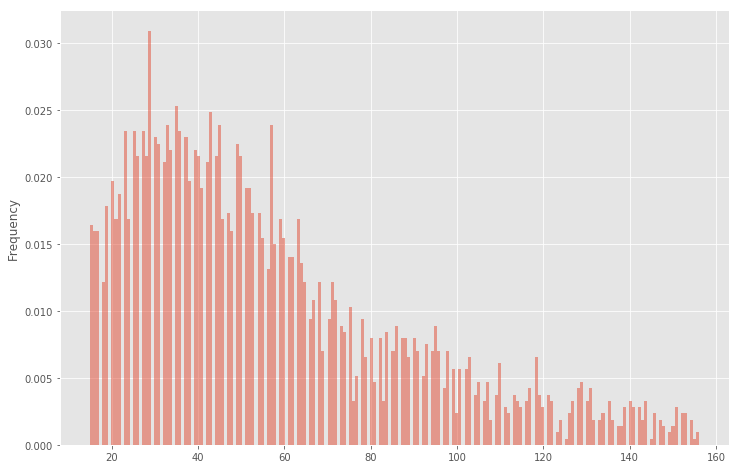

In [23]:
# Plot for comparison
plt.figure(figsize=(12,8))
ax = f_duration.plot(kind='hist', bins=200, density=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

(0.0, 0.03246296972933463)

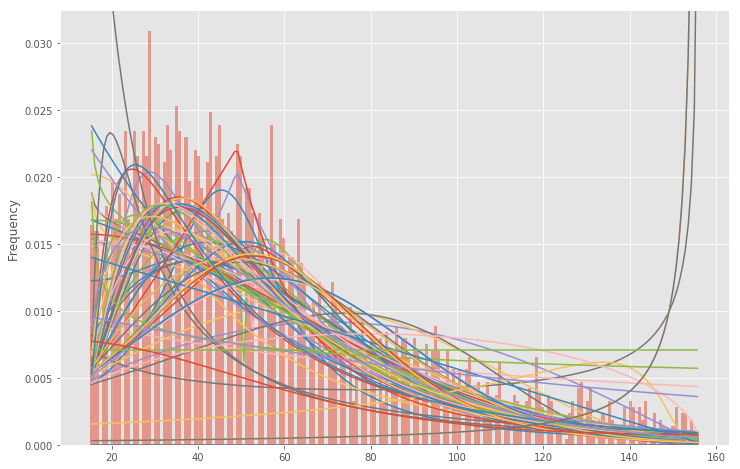

In [24]:
# Plot for comparison
plt.figure(figsize=(12,8))
ax = f_duration.plot(kind='hist', bins=200, density=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()


# Best holders
best_distribution = st.norm
best_params = (0.0, 1.0)
best_sse = np.inf

# Estimate distribution parameters from data
for distribution in DISTRIBUTIONS:
    # Try to fit the distribution
    try:
        # Ignore warnings from data that can't be fit
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')

            # fit dist to data
            params = distribution.fit(f_duration)

            # Separate parts of parameters
            arg = params[:-2]
            loc = params[-2]
            scale = params[-1]

            # Calculate fitted PDF and error with fit in distribution
            pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
            sse = np.sum(np.power(y - pdf, 2.0))

            # add to plot
            try:
                if ax:
                    pd.Series(pdf, x).plot(ax=ax)
                end
            except Exception:
                pass

            # identify if this distribution is better
            if best_sse > sse > 0:
                best_distribution = distribution
                best_params = params
                best_sse = sse

    except Exception:
        pass

ax.set_ylim(dataYLim)

best_dist c
param_str c=1.29, loc=14.64, scale=45.39
dist_str frechet_r(c=1.29, loc=14.64, scale=45.39)


/Users/yuyunli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `frechet_r` is deprecated!
The distribution `frechet_r` is a synonym for `weibull_min`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_min`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
  # Remove the CWD from sys.path while we load stuff.
/Users/yuyunli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `frechet_r` is deprecated!
The distribution `frechet_r` is a synonym for `weibull_min`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_min`.  For the Frechet distribution (i.e. the Type II
extreme value distribut

Text(0,0.5,'Frequency')

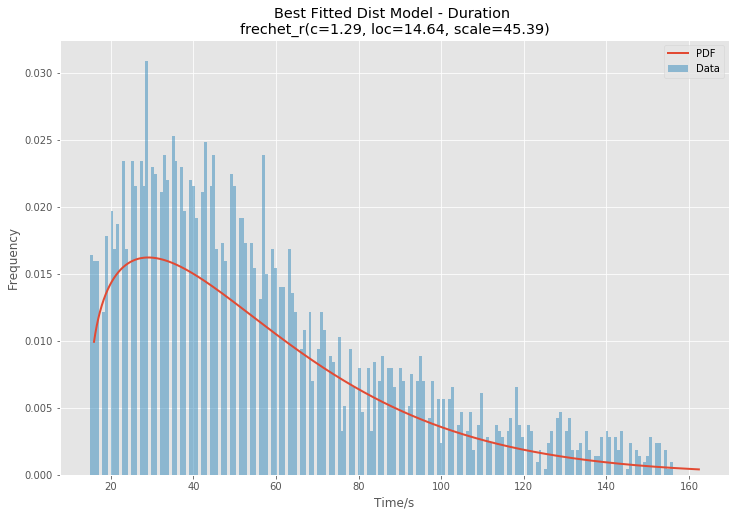

In [26]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Make PDF
pdf = make_pdf(best_distribution, best_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
f_duration.plot(kind='hist', bins=200, density=True, alpha=0.5, label='Data', legend=True, ax=ax)


best_dist = getattr(st, best_distribution.name)
print('best_dist', best_dist.shapes)
param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_params)])
print('param_str', param_str)
dist_str = '{}({})'.format(best_distribution.name, param_str)
print('dist_str', dist_str)

ax.set_title('Best Fitted Dist Model - Duration \n' + dist_str)
ax.set_xlabel('Time/s')
ax.set_ylabel('Frequency')